# TensorFlor CNN and image processing

This notebook contains the python code responsible for loading, processing and labeling the images taken by our camScript.py program on our Raspberry Pi 5. The notebook also contains the code for our CNN model specification and code for using the model.

The model in use is a sequential model.

After building the model, we feed it a test image and see if it can correctly classify it.

We also have code in this file for converting the model to a TFLite model, which is smaller in size, such that it can hopefully live on a microcontroller.

In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
to_categorical = tf.keras.utils.to_categorical

2025-04-26 14:42:09.352525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-26 14:42:09.472356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745671329.526451    5813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745671329.541803    5813 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745671329.636120    5813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Image Processing

This python program was created to, process the images, which will be used to train our CNN. 

The program loads the images from the 'Puctures' directory, then rotates them 90 degrees clockwize, to make them appear up right.


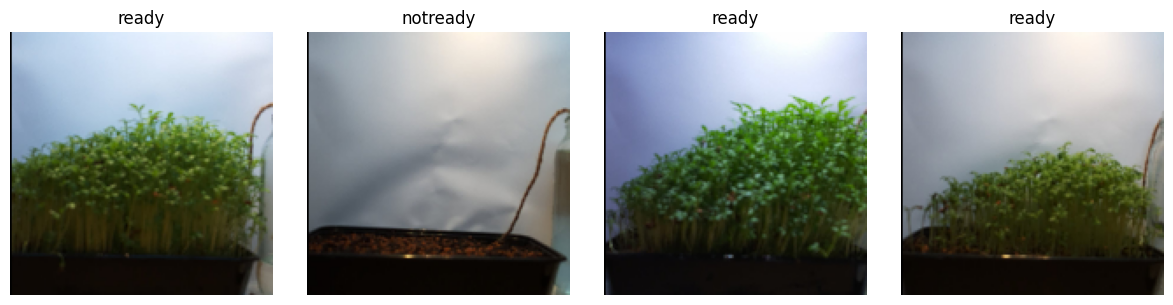

In [ ]:
'''
Made with help from:
1. https://www.geeksforgeeks.org/image-processing-in-python/
2. ChatGPT
3. https://www.photopea.com/
4. https://stackoverflow.com/questions/15589517/how-to-crop-an-image-in-opencv-using-python
'''

# Define image parameters
IMAGE_SIZE = (150,150)
DATASET_PATH = "../Local_Things/Pictures"
img_start_x, img_start_y =  500, 190# 1550, 120
crop_amount = 890
# Lists to store images and labels
x_data = []
y_data = []

# Get class names from directory
class_names = sorted(os.listdir(DATASET_PATH))  # Ensures labels are consistent
class_indices = {name: idx for idx, name in enumerate(class_names)}  # Assigns class numbers

# Process each class folder
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Skipping {img_name}, could not read.")
            continue

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize image
        img = img[img_start_y:img_start_y+crop_amount,img_start_x:img_start_x+crop_amount]
        img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC)

        # Rotate image if needed
        center = (img.shape[1] // 2, img.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle=-90, scale=1)
        img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))

        # Normalize pixel values (optional but recommended)
        img = img / 255.0

        # Store processed image and corresponding label
        x_data.append(img)
        y_data.append(class_indices[class_name])  # Integer label

# Convert lists to NumPy arrays
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.int32)

# Convert labels to one-hot encoding
y_data = to_categorical(y_data, num_classes=len(class_names))

# Split into training & testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Plot images to see of they are processed correctly
def plot_images(images, labels, class_names, images_per_row=5):
    total_images = len(images)
    rows = math.ceil(total_images / images_per_row)  # Calculate needed rows

    plt.figure(figsize=(images_per_row * 3, rows * 3))  # Adjust figure size dynamically
    
    for i in range(total_images):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_images(x_train, y_train, class_names)

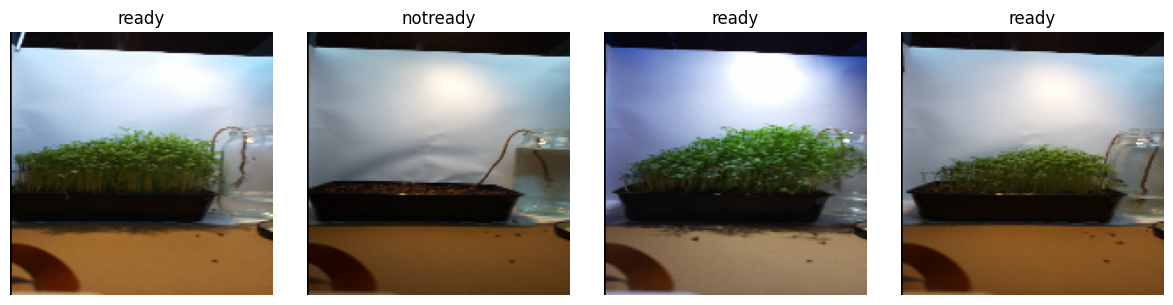

In [ ]:
'''
Made with help from:
1. https://www.geeksforgeeks.org/image-processing-in-python/
2. ChatGPT
'''
'''
# Define image parameters
IMAGE_SIZE = (150, 150)
DATASET_PATH = "../Local_Things/Pictures"

# Lists to store images and labels
x_data = []
y_data = []

# Get class names from directory
class_names = sorted(os.listdir(DATASET_PATH))  # Ensures labels are consistent
class_indices = {name: idx for idx, name in enumerate(class_names)}  # Assigns class numbers

# Process each class folder
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Skipping {img_name}, could not read.")
            continue

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize image
        img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC)

        # Rotate image if needed
        center = (img.shape[1] // 2, img.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle=-90, scale=1)
        img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))

        # Normalize pixel values (optional but recommended)
        img = img / 255.0  

        # Store processed image and corresponding label
        x_data.append(img)
        y_data.append(class_indices[class_name])  # Integer label

# Convert lists to NumPy arrays
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.int32)

# Convert labels to one-hot encoding
y_data = to_categorical(y_data, num_classes=len(class_names))

# Split into training & testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Plot images to see of they are processed correctly
def plot_images(images, labels, class_names, images_per_row=5):
    total_images = len(images)
    rows = math.ceil(total_images / images_per_row)  # Calculate needed rows

    plt.figure(figsize=(images_per_row * 3, rows * 3))  # Adjust figure size dynamically
    
    for i in range(total_images):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_images(x_train, y_train, class_names)
'''

## CNN Model Training

We're using a sequencial model from the getting started section of the tensorflow website:
https://www.tensorflow.org/tutorials/quickstart/beginner

In [4]:
# Define a CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

print(y_train.shape)

# Compile the model with correct loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

# Ensure x_train and y_train are in the correct format
print(f"x_train shape: {x_train.shape}")  # Should be (num_samples, 150, 150, 3)
print(f"y_train shape: {y_train.shape}")  # Should be (num_samples,)

# Train the model
model.fit(x_train, y_train, epochs=5)

# Evaluate on test set
model.evaluate(x_test, y_test, verbose=2)

# Create a probability model for predictions
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

# Get predictions
predictions = probability_model(x_test[:5])
print(predictions)


/home/bdamunix123/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(110, 2)
x_train shape: (110, 150, 150, 3)
y_train shape: (110, 2)
Epoch 1/5


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.4766 - loss: 2.3306
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.5099 - loss: 0.9745
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.6331 - loss: 0.6272
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.9422 - loss: 0.4320
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.8709 - loss: 0.2849
1/1 - 0s - 295ms/step - accuracy: 0.9286 - loss: 0.2276
tf.Tensor(
[[0.02552446 0.97447556]
 [0.04496679 0.95503324]
 [0.8060899  0.19391009]
 [0.44652244 0.5534775 ]
 [0.8691507  0.13084935]], shape=(5, 2), dtype=float32)


## Save the model (Size: 122M)

In [5]:
model.save("my_model.h5")

## Convert model to TFLite model (Size 11M)

The idea is to have a model that will fit on a microcontroller. The model will still be trained on a device with the necessary capabilities.

By converting the model to a TFLite model, and using the converter.optimizations method as shown below, we have managed to reduce the size of the model from 122M to 11M.

In [6]:
# Load the model
MODEL_PATH = "my_model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# Convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert all float32 to int8, minimizing the model, making it about 4 times smaller.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = 'my_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpc8wuhvt3/assets


INFO:tensorflow:Assets written to: /tmp/tmpc8wuhvt3/assets


Saved artifact at '/tmp/tmpc8wuhvt3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140370139465680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140370139470608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140369465181984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140369465184096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140369465195536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140369465331024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140369465337360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140369465335424: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1745312096.379483    1125 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745312096.379610    1125 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-22 10:54:56.380279: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpc8wuhvt3
2025-04-22 10:54:56.382688: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-22 10:54:56.382718: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpc8wuhvt3
I0000 00:00:1745312096.393647    1125 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-22 10:54:56.395302: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-22 10:54:56.504009: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpc8wuhvt3
2025-04-22 10:54:56.513817: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

# Using the trained model (the original, not the tfLite)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Class Probabilities: [[0.02776805 0.972232  ]]


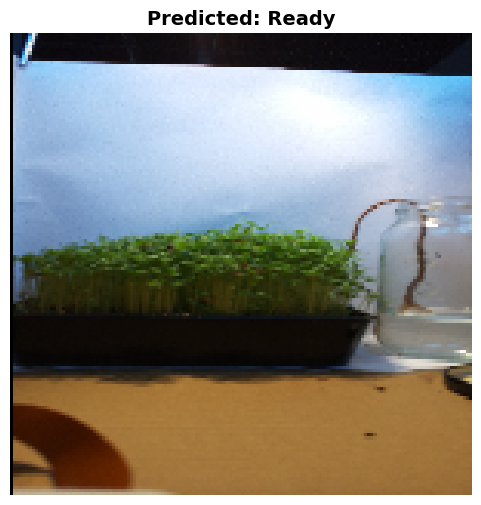

In [7]:
# Define constants
IMAGE_SIZE = (150, 150)  # Same as training size
MODEL_PATH = "my_model.h5"  # Path to your trained model
IMAGE_PATH = "../Local_Things/Test_images/Cress1_2025-03-03_07:40:14.jpg"  # Replace with actual image path

# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, IMAGE_SIZE)  # Resize
    center = (img.shape[1] // 2, img.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle=-90, scale=1)
    img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
    img = img / 255.0  # Normalize
    img_expanded = np.expand_dims(img, axis=0)  # Add batch dimension
    return img, img_expanded  # Return both original and processed images

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Preprocess input image
original_image, image = preprocess_image(IMAGE_PATH)

# Get model prediction
prediction = model.predict(image)

# Convert probabilities to class label
predicted_class = np.argmax(prediction)  # 0 or 1

# Define class names (Modify according to your dataset)
class_names = ["Not ready", "Ready"]  # Replace with actual class names
predicted_label = class_names[predicted_class] 

# Print probabilities
probabilities = tf.nn.softmax(prediction).numpy() 
print(f"Class Probabilities: {probabilities}")

# Plot image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()

## Using the tfLite Model

Class Probabilities: [[0.02785247 0.9721476 ]]


/home/bdamunix123/.local/lib/python3.10/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


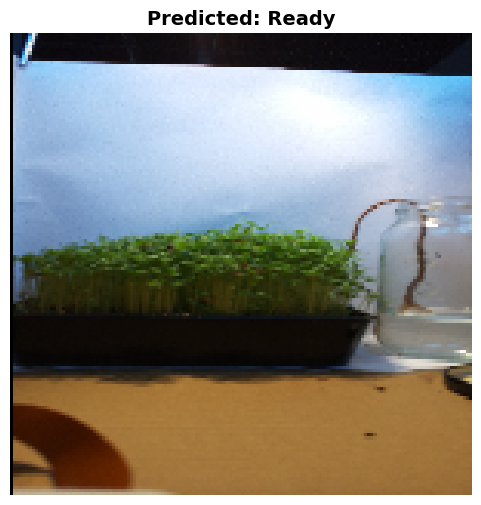

In [8]:
MODEL_PATH = "my_model.tflite"  # Path to your trained model

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocess input image
original_image, image = preprocess_image(IMAGE_PATH)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], image.astype(np.float32))

# Run inference
interpreter.invoke()

# Get output tensor
prediction = interpreter.get_tensor(output_details[0]['index'])

# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(prediction).numpy() 

# Convert to class label (the one with the highest probability)
predicted_class = np.argmax(probabilities)  # 0 or 1

# Print out the probabilities
print(f"Class Probabilities: {probabilities}")

# Plot image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()

## Training and using MobileNet v3 model with our own data

/home/bdamunix123/.local/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 832ms/step - accuracy: 0.6535 - loss: 0.6050 - val_accuracy: 0.5714 - val_loss: 0.6991
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - accuracy: 0.8059 - loss: 0.5104 - val_accuracy: 0.5714 - val_loss: 0.6974
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - accuracy: 0.7466 - loss: 0.4979 - val_accuracy: 0.5714 - val_loss: 0.6979
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - accuracy: 0.8012 - loss: 0.4572 - val_accuracy: 0.5714 - val_loss: 0.6980
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.8112 - loss: 0.4180 - val_accuracy: 0.5714 - val_loss: 0.6972
1/1 - 0s - 123ms/step - accuracy: 0.5714 - loss: 0.6972


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class Probabilities: [[0.57568073 0.4243193 ]]


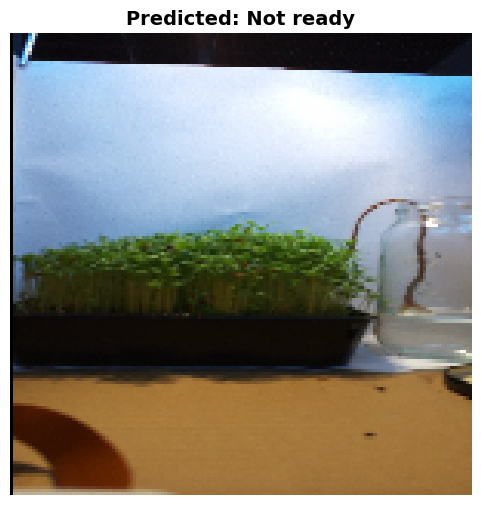

In [15]:
# https://www.kaggle.com/models/timm/tf-mobilenet-v3
# Made with help from chatGPT

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models, optimizers

# Load MobileNetV3 with 150x150 input shape
base_model = MobileNetV3Small(input_shape=(150, 150, 3), include_top=False, weights='imagenet')  # No pretrained weights

# Add classification layers
mobileNetv3_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')  # Adjust based on number of classes
])

# Set learning rate to 0.0004
mobileNetv3_model.compile(optimizer=optimizers.SGD(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

mobileNetv3_model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

mobileNetv3_model.evaluate(x_test, y_test, verbose=2)

prediction = mobileNetv3_model.predict(image)

predicted_class = np.argmax(prediction)
# Convert probabilities to class label
class_names = ["Not ready", "Ready"]  # 0 or 1
predicted_label = class_names[predicted_class] 

# Print probabilities
probabilities = tf.nn.softmax(prediction).numpy() 
print(f"Class Probabilities: {probabilities}")

# Plot image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()

### Saving the MobileNetV3Small model (Size: 12M)

In [ ]:
mobileNetv3_model.save("MobileNetV3Small.h5")

## Training and using EfficientNet v2 model with our own data

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7564 - loss: 0.5006
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 993ms/step - accuracy: 0.9964 - loss: 0.0639
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9854 - loss: 0.0516
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 951ms/step - accuracy: 1.0000 - loss: 0.0144
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 975ms/step - accuracy: 0.9906 - loss: 0.0191
1/1 - 2s - 2s/step - accuracy: 0.5714 - loss: 0.9752
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class Probabilities: [[0.68073595 0.31926408]]


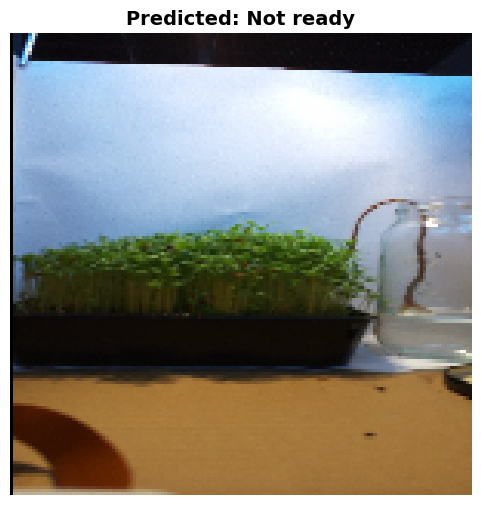

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models

# Load EfficientNetV2B0 model
base_model = EfficientNetV2B0(input_shape=(150, 150, 3), include_top=False, weights='imagenet')  # Pretrained on ImageNet

# Add classification layers on top
EfficientNetV2B0_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')  # Adjust for your number of classes
])

# Compile the model (if needed)
EfficientNetV2B0_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetV2B0_model.fit(x_train, y_train, epochs=5, batch_size=32)

EfficientNetV2B0_model.evaluate(x_test, y_test, verbose=2)

prediction = EfficientNetV2B0_model.predict(image)

predicted_class = np.argmax(prediction)
# Convert probabilities to class label
class_names = ["Not ready", "Ready"]  # 0 or 1
predicted_label = class_names[predicted_class] 

# Print probabilities
probabilities = tf.nn.softmax(prediction).numpy() 
print(f"Class Probabilities: {probabilities}")

# Plot image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.title(f"Predicted: {predicted_label}", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()

### Saving the EfficientNetV2B0 model (Size 70M)

In [ ]:
EfficientNetV2B0_model.save("EfficientNetV2B0.h5")

## Thoughts

Our own trained model has a very high accuracy and low loss compared to MobileNetV3Small and EfficientNetv2B0.
Our TFLite model has a size of 11M, shrinked from the original 122M

The results show that when feeding the models a test image, our own model is alot better at classifying.

Maybe the Mobilenet and efficientNet models are trash because they expext some specific input size.

The mobileNet model needs to be quantized in order to reduce the size enough to fit in on a microcontroller.

## Quantizing the MobileNet model (making it smaller)

In [ ]:
# Load the model
MODEL_PATH = "MobileNetV3Small.h5"

from tensorflow.keras.utils import get_custom_objects

model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects=get_custom_objects()
)

# Convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert all float32 to int8, minimizing the model, making it about 4 times smaller.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = 'MobileNetV3Small.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)